<a href="https://colab.research.google.com/github/EmanSalah2000/ExctractFeatureToDetectSleepingStage/blob/main/BCI_Assignment_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==0.23.2
!pip install mne
!pip install mne_features==0.1

     |████████████████████████████████| 6.8 MB 4.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
     |████████████████████████████████| 7.4 MB 4.1 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from mne.datasets.sleep_physionet.age import fetch_data
from mne_features.feature_extraction import extract_features
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
files = []
for i in range(21):
  person_file = fetch_data(subjects=[i], recording=[1])
  files.append(person_file)

files = np.array(files)
print(files.shape)

mapping={'EOG horizontal':'eog',
             'Resp oro-nasal':'resp',
             'EMG submental':'emg',
             'Temp rectal' :'misc',
             'Event marker':'misc'}


raw = [0 for i in range(21)]
annot = [0 for i in range(21)]

for i in range(21):
  raw[i] = mne.io.read_raw_edf(files[i][0][0])
  annot[i] = mne.read_annotations(files[i][0][1])
  raw[i].set_annotations(annot[i], emit_warning=False)
  raw[i].set_channel_types(mapping)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


Using default location ~/mne_data for PHYSIONET_SLEEP...


(21, 1, 2)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...


In [ ]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}


events = [0 for i in range(21)]

for i in range(21):
    annot[i].crop(annot[i][1]['onset'] - 30 * 60,
                 annot[i][-2]['onset'] + 30 * 60)
    raw[i].set_annotations(annot[i], emit_warning=False)

    events[i], _ = mne.events_from_annotations(raw[i], event_id=annotation_desc_2_event_id, chunk_duration=30.)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 

In [ ]:
event_id = {'Sleep stage W': 1,
                'Sleep stage 1': 2,
                'Sleep stage 2': 3,
                'Sleep stage 3/4': 4,
                'Sleep stage R': 5}

epochs = [0 for i in range(21)]

for i in range(21):  
  tmax = 30. - 1. / raw[i].info['sfreq']         # sampling frequency = 100
  reject_criteria = dict(
                        eeg=150e-6,
                        eog=250e-6)      
  epochs[i] = mne.Epochs(raw=raw[i], events=events[i],
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, reject=reject_criteria)

Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
1235 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
976 matching events found
No baseline correction applied
0 

In [ ]:
psds = [0 for i in range(21)]
freqs = [0 for i in range(21)]

for i in range(21):
    psds[i], freqs[i] = psd_welch(epochs[i], picks='eeg', fmin=0.5, fmax=30.)

Streaming output truncated to the last 5000 lines.
    Rejecting  epoch based on EOG : ['EOG horizontal']
    Rejecting  epoch based on EOG : ['EOG horizontal']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EOG : ['EOG horizontal']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoch based on EEG : ['EEG Fpz-Cz']
    Rejecting  epoc

In [ ]:
x=[0 for i in range(21)]
y=[0 for i in range(21)]

f_std, f_zero_crosses, f_entropy, f_hjorth_complexity = [], [], [], []

for i in range(21):
    x[i]= epochs[i].get_data()[:,:2,:]
    y[i] = epochs[i].events[:,2]
       
    f_std_perepoch = x[i].std(axis=2)
    f_std.append(f_std_perepoch)
    
    f_zero_crosses_perepoch = ((x[i][:,:,:-1] * x[i][:,:,1:]) < 0).sum(axis=2)
    f_zero_crosses.append(f_zero_crosses_perepoch)
    
    selected_funcs = {'app_entropy'}
    f_entropy_perepochs = extract_features(x[i], raw[i].info['sfreq'], selected_funcs)
    f_entropy.append(f_entropy_perepochs)


    selected_funcs = {'hjorth_complexity'}
    f_hjorth_complexity_perepochs = extract_features(x[i], raw[i].info['sfreq'], selected_funcs)
    f_hjorth_complexity.append(f_hjorth_complexity_perepochs)

Loading data for 345 events and 3000 original time points ...
Loading data for 714 events and 3000 original time points ...
Loading data for 522 events and 3000 original time points ...
Loading data for 380 events and 3000 original time points ...
Loading data for 794 events and 3000 original time points ...
Loading data for 240 events and 3000 original time points ...
Loading data for 221 events and 3000 original time points ...
Loading data for 572 events and 3000 original time points ...
Loading data for 167 events and 3000 original time points ...
Loading data for 656 events and 3000 original time points ...
Loading data for 748 events and 3000 original time points ...
Loading data for 566 events and 3000 original time points ...
Loading data for 815 events and 3000 original time points ...
Loading data for 421 events and 3000 original time points ...
Loading data for 466 events and 3000 original time points ...
Loading data for 484 events and 3000 original time points ...
Loading 

In [ ]:
print(len(f_std))
print(len(f_zero_crosses))
print(len(f_entropy))
print(len(f_hjorth_complexity))
print(len(y))

21
21
21
21
21


In [ ]:
train_std_flat = out = np.concatenate(f_std[:16]).ravel().tolist()
train_zero_crossing_flat = np.concatenate(f_zero_crosses[:16]).ravel().tolist()
train_entropy_flat = np.concatenate(f_entropy[:16]).ravel().tolist()
train_hjorth_comlexity_flat = np.concatenate(f_hjorth_complexity[:16]).ravel().tolist()
train_flatten_y = np.concatenate(y[:16]).ravel().tolist()

print(len(train_std_flat))
print(len(train_flatten_y))

print(len(train_zero_crossing_flat))

16222
8111
16222


In [ ]:
test_std_flat = np.concatenate(f_std[16:]).ravel().tolist()
test_zero_crossing_flat = np.concatenate(f_zero_crosses[16:]).ravel().tolist()
test_entropy_flat = np.concatenate(f_entropy[16:]).ravel().tolist()
test_hjorth_comlexity_flat = np.concatenate(f_hjorth_complexity[16:]).ravel().tolist()
test_flatten_y = np.concatenate(y[16:]).ravel().tolist()

print(len(test_std_flat))
print(len(test_flatten_y))



5962
2981


In [ ]:
train_features = np.vstack([train_std_flat, train_zero_crossing_flat, train_entropy_flat, train_hjorth_comlexity_flat]).T
test_features = np.vstack([test_std_flat, test_zero_crossing_flat, test_entropy_flat, test_hjorth_comlexity_flat]).T
x_train = np.array(train_features).reshape((8111, 8))
x_test = np.array(test_features).reshape((2981, 8))
y_train = np.array(train_flatten_y)
y_test = np.array(test_flatten_y)

print(train_features.shape)
print(test_features.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16222, 4)
(5962, 4)
(8111, 8)
(2981, 8)
(8111,)
(2981,)


Accuracy: 66.45420999664542 %

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00       153
           3       0.66      1.00      0.80      1969
           4       1.00      0.07      0.14       177
           5       0.00      0.00      0.00       512

    accuracy                           0.66      2981
   macro avg       0.33      0.21      0.19      2981
weighted avg       0.50      0.66      0.54      2981

Feature: 0, Score: 0.04434
Feature: 1, Score: 0.14385
Feature: 2, Score: 0.27782
Feature: 3, Score: 0.04821
Feature: 4, Score: 0.00570
Feature: 5, Score: 0.12113
Feature: 6, Score: 0.26481
Feature: 7, Score: 0.09414


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


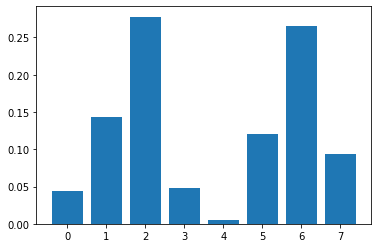

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print("Accuracy:", acc * 100, "%\n")

print(classification_report(y_test, y_predict))

importance = clf.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

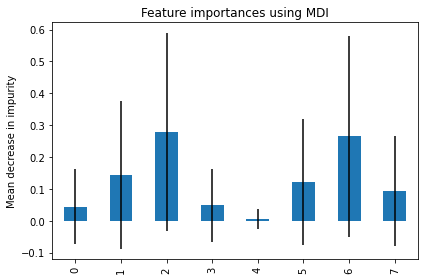

In [ ]:
import pandas as pd

importances = clf.feature_importances_

forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Accuracy: 58.47031197584703 %

              precision    recall  f1-score   support

           1       0.22      0.25      0.23       170
           2       0.16      0.28      0.20       153
           3       0.75      0.73      0.74      1969
           4       0.78      0.54      0.64       177
           5       0.27      0.25      0.26       512

    accuracy                           0.58      2981
   macro avg       0.43      0.41      0.41      2981
weighted avg       0.61      0.58      0.60      2981

Feature: 0, Score: 0.16295
Feature: 1, Score: 0.12371
Feature: 2, Score: 0.14006
Feature: 3, Score: 0.12781
Feature: 4, Score: 0.07595
Feature: 5, Score: 0.11442
Feature: 6, Score: 0.16117
Feature: 7, Score: 0.09394


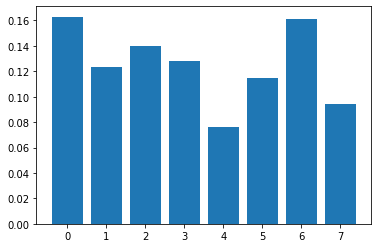

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree = decisiontree.fit(x_train, y_train)
y_predict = decisiontree.predict(x_test)

acc = accuracy_score(y_test, y_predict)
print("Accuracy:", acc * 100, "%\n")

print(classification_report(y_test, y_predict))

importance = decisiontree.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
y_predict = neigh.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print("Accuracy:", acc * 100, "%\n")

print(classification_report(y_test, y_predict))

Accuracy: 49.98322710499832 %

              precision    recall  f1-score   support

           1       0.11      0.21      0.14       170
           2       0.10      0.23      0.14       153
           3       0.68      0.67      0.68      1969
           4       0.61      0.26      0.37       177
           5       0.16      0.09      0.12       512

    accuracy                           0.50      2981
   macro avg       0.33      0.29      0.29      2981
weighted avg       0.53      0.50      0.51      2981



Accuracy: 65.2130157665213 %

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       170
           2       0.15      0.05      0.07       153
           3       0.66      0.98      0.79      1969
           4       0.00      0.00      0.00       177
           5       0.00      0.00      0.00       512

    accuracy                           0.65      2981
   macro avg       0.16      0.21      0.17      2981
weighted avg       0.44      0.65      0.53      2981

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00100
Feature: 2, Score: -0.01716
Feature: 3, Score: -0.18648
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00263
Feature: 6, Score: -0.01734
Feature: 7, Score: -0.21470


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


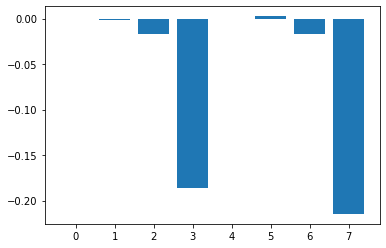

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)

y_predict = model.predict(x_test)

acc = accuracy_score(y_test, y_predict)
print("Accuracy:", acc * 100, "%\n")
print(classification_report(y_test, y_predict))

importance = model.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Accuracy: 67.32640053673265 %

              precision    recall  f1-score   support

           1       0.40      0.20      0.27       170
           2       0.00      0.00      0.00       153
           3       0.72      0.96      0.82      1969
           4       0.86      0.14      0.24       177
           5       0.27      0.13      0.18       512

    accuracy                           0.67      2981
   macro avg       0.45      0.29      0.30      2981
weighted avg       0.59      0.67      0.60      2981

Feature: 0, Score: 0.00036
Feature: 1, Score: 0.00695
Feature: 2, Score: -1.98402
Feature: 3, Score: 0.41230
Feature: 4, Score: 0.00024
Feature: 5, Score: -0.00218
Feature: 6, Score: 0.45036
Feature: 7, Score: -1.28543


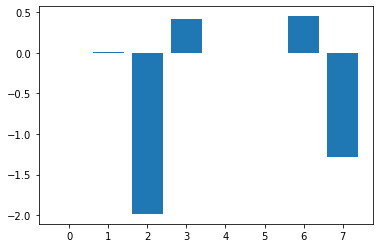

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(x_train, y_train)

y_predict = svm.predict(x_test)

acc = accuracy_score(y_test, y_predict)
print("Accuracy:", acc * 100, "%\n")

print(classification_report(y_test, y_predict))

importance = svm.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()